In [1]:
from random import randint
import os
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle




os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = ""


from sklearn.metrics import accuracy_score , roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, Input
from tensorflow.keras.layers import Flatten, MaxPool2D, AvgPool2D
from tensorflow.keras.layers import BatchNormalization, Reshape, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model, load_model
import tensorflow as tf
from PIL import Image

seed = 123

## Tratamento, balanceamento e split de treino e teste de descritivos

In [2]:
# # Caminhos dos  csvs (win):
# treino_2018 =r"D:\ISIC\isic_2018_treino.csv"
# treino_2017 =r"D:\ISIC\isic_2017_treino.csv"
# teste =      r"D:\ISIC\isic_2017_teste.csv"
# validacao =  r"D:\ISIC\isic_2017_validacao.csv"

In [3]:
#Caminhos dos  csvs:
treino_2018 ="/media/leandro/2AC8-9C09/ISIC/isic_2018_treino.csv"
treino_2017 ="/media/leandro/2AC8-9C09/ISIC/isic_2017_treino.csv"
teste =      "/media/leandro/2AC8-9C09/ISIC/isic_2017_teste.csv"
validacao =  "/media/leandro/2AC8-9C09/ISIC/isic_2017_validacao.csv"


In [4]:
# primeiramente, abrimos os descritivos dos dados de treino, a fim de analisar o balanceamento dos dados;
# julgamos válido ajustar a rede a um conjunto de dados balanceado, assim, evitando enviesar a rede

df_treino_2017 = pd.read_csv(treino_2017)
df_treino_2018 = pd.read_csv(treino_2018)

In [5]:
# analisando descritivo de treino de 2017
df_treino_2017.head()

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0000000,0.0,0.0
1,ISIC_0000001,0.0,0.0
2,ISIC_0000002,1.0,0.0
3,ISIC_0000003,0.0,0.0
4,ISIC_0000004,1.0,0.0


In [6]:
# ------- TREINO 2017

df_treino_2017['image_id'] = df_treino_2017['image_id'].apply(lambda x: x + '.jpg')
df_treino_2017['nevus'] = ((df_treino_2017['melanoma'] == 0) & 
                           (df_treino_2017['seborrheic_keratosis'] == 0)).astype(float)
df_treino_2017.drop('seborrheic_keratosis', axis = 1, inplace = True)
df_treino_2017 = df_treino_2017.loc[(df_treino_2017['melanoma'] == 1) | (df_treino_2017['nevus'] == 1)]

# nesta célula, adicionamos extensões aos nomes dos arquivos, para que estes correspondam exatamente aos nomes
# que de fato seriam usados para acessar as imagens, por código, em seguida, precisávamos saber quais imagens
# eram casos de 'nevus', como esta flag não existe, inferimos que casos que não fossem 'melanoma', nem 
# 'seborrheic_keratosis' seriam 'nevus', à partir disso, criamos uma terceira flag, eliminamos a flag
# 'seborrheic_keratosis', que não nos convinha, por fim, mantivemos no dataframe, apenas as imagens
# que representassem ou casos de 'nevus' ou 'melanoma'

In [7]:
df_treino_2017.head()

,image_id,melanoma,nevus
0,ISIC_0000000.jpg,0.0,1.0
1,ISIC_0000001.jpg,0.0,1.0
2,ISIC_0000002.jpg,1.0,0.0
3,ISIC_0000003.jpg,0.0,1.0
4,ISIC_0000004.jpg,1.0,0.0


In [8]:
# partimos para o descritivo de treino de 2018

df_treino_2018.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# ------- TREINO 2018

df_treino_2018['image'] = df_treino_2018['image'].apply(lambda x: x + '.jpg')
df_treino_2018 = df_treino_2018.loc[(df_treino_2018['MEL'] == 1) | (df_treino_2018['NV'] == 1)]
df_treino_2018 = df_treino_2018[['image', 'MEL', 'NV']]
# nesta célula, apenas adicinamos as extensões aos nomes dos arquivos, filtramos imagens que representassem 
# casos de 'nevus' ou 'melanoma', por meio das flags 'NEV' e 'ML'

In [10]:
df_treino_2018.head()

,image,MEL,NV
0,ISIC_0024306.jpg,0.0,1.0
1,ISIC_0024307.jpg,0.0,1.0
2,ISIC_0024308.jpg,0.0,1.0
3,ISIC_0024309.jpg,0.0,1.0
4,ISIC_0024310.jpg,1.0,0.0


In [11]:
# aqui, unificamos os nomes das series dos descritivos, para que possam ser concatenados
df_treino_2018.columns = ['img', 'pos', 'neg']
df_treino_2017.columns = ['img', 'pos', 'neg']

In [12]:
# como podemos ver abaixo, as bases estão desbalanceadas

In [13]:
df_treino_2017['pos'].value_counts(1)

0.0    0.785796
1.0    0.214204
Name: pos, dtype: float64

In [14]:
df_treino_2018['pos'].value_counts(1)

0.0    0.857636
1.0    0.142364
Name: pos, dtype: float64

In [15]:
# nesta célula, juntamos as duas bases, como o intuito de obter um conjunto balanceado de dados

# separando casos positivos e negativos de cada ano
pos_2018 = df_treino_2018.loc[df_treino_2018['pos'] == 1]
pos_2017 = df_treino_2017.loc[df_treino_2017['pos'] == 1]

neg_2018 = df_treino_2018.loc[df_treino_2018['neg'] == 1]
neg_2017 = df_treino_2017.loc[df_treino_2017['neg'] == 1]

# juntando casos positivos e negativos de todos os anos
full_pos = pd.concat([pos_2017, pos_2018], axis = 0)
full_neg = pd.concat([neg_2017, neg_2018], axis = 0)

# amostrando aleatoriamente, n dados negativos, estes consistirão nas observações negativas (a amostragem
# é feita para separar um número de imagens equivalente ao número de imagens positivas que temos à disposição)
full_neg = full_neg.sample(n = full_pos.shape[0], random_state = seed)

full_pos = full_pos[['img', 'pos', 'neg']]
full_neg = full_neg[['img', 'pos', 'neg']]

filenames = pd.concat([full_pos, full_neg]).reset_index().drop('index', axis = 1)

filenames['pos'].value_counts()

0.0    1487
1.0    1487
Name: pos, dtype: int64

# na célula abaixo, separo 20% das imagens para teste
### na hora de tirar a métrica, carregar 'df_teste' com a função 'get_images_n_labels' e testar na rede

In [16]:
# com base no conjunto balanceado, obtemos splits de treino e teste
df_treino, df_teste = train_test_split(filenames, test_size = 0.2, random_state = seed)

In [17]:
# analisamos aqui, o descritivo de validação

df_valid = pd.read_csv(validacao)

In [18]:
df_valid.head()

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0001769,0.0,0.0
1,ISIC_0001852,0.0,0.0
2,ISIC_0001871,0.0,0.0
3,ISIC_0003462,0.0,0.0
4,ISIC_0003539,0.0,0.0


In [19]:
df_valid['image_id'] = df_valid['image_id'].apply(lambda x: x + '.jpg')
df_valid['nevus'] = ((df_valid['melanoma'] == 0) & 
                           (df_valid['seborrheic_keratosis'] == 0)).astype(float)
df_valid.drop('seborrheic_keratosis', axis = 1, inplace = True)
df_valid = df_valid.loc[(df_valid['melanoma'] == 1) | (df_valid['nevus'] == 1)]

df_valid.columns = ['img', 'pos', 'neg']
# para o tratamento do descritivo de validação, foi necessário adicionar extensões e criar a flag 'nevus', 
# de forma similar ao tratamento do descritivo de 2017, além disso, filtramos por apenas casos de 
# 'melanoma' ou 'nevus', também foram aplicados os mesmos nomes para as series 

In [20]:
df_valid.head()

,img,pos,neg
0,ISIC_0001769.jpg,0.0,1.0
1,ISIC_0001852.jpg,0.0,1.0
2,ISIC_0001871.jpg,0.0,1.0
3,ISIC_0003462.jpg,0.0,1.0
4,ISIC_0003539.jpg,0.0,1.0


In [21]:
# como podemos observar, a base de validação está desbalanceada

df_valid['pos'].value_counts(1)

0.0    0.722222
1.0    0.277778
Name: pos, dtype: float64

In [22]:
# para balanceá-la, elminaremos casos negativos o suficiente para que o número resultante se equipare 
# ao número de casos positivos

df_valid_pos = df_valid.loc[df_valid['pos'] == 1]
df_valid_neg = df_valid.loc[df_valid['neg'] == 1]

In [23]:
len(df_valid_pos), len(df_valid_neg)

# amostraremos 30 valores aleatórios dentre os casos negativos, e estes serão concatenados ao conjunto de
# casos positivos, o conjunto resultante consistirá no descritivo de validação

(30, 78)

In [24]:
df_valid_neg = df_valid_neg.sample(30, random_state = seed)
df_valid = pd.concat([df_valid_pos, df_valid_neg])

In [25]:
df_valid['pos'].value_counts(1)

0.0    0.5
1.0    0.5
Name: pos, dtype: float64

In [26]:
# descritivo de teste (cujas predições devemos entregar)

df_pred = pd.read_csv(teste)

In [27]:
df_pred.head()

,image_id
0,ISIC_0012086
1,ISIC_0012092
2,ISIC_0012095
3,ISIC_0012134
4,ISIC_0012136


In [28]:
df_pred['image_id'] = df_pred['image_id'].apply(lambda x: x + '.jpg')
df_pred.columns = ['img']

# para o tratamento do descritivo de teste, aplicamos extensões e unificamos nome da series

In [29]:
df_pred.head()

,img
0,ISIC_0012086.jpg
1,ISIC_0012092.jpg
2,ISIC_0012095.jpg
3,ISIC_0012134.jpg
4,ISIC_0012136.jpg


In [30]:
# ao final do processo, possuímos df_treino, df_teste, df_valid, df_pred

In [31]:
df_treino = df_treino.reset_index()
df_valid = df_valid.reset_index()
df_treino.drop('index', axis = 1, inplace = True)
df_valid.drop('index', axis = 1, inplace = True)

## Pré-processamento

In [32]:
# farei o pré processamento das imagens conforme estiver alimentando o ajuste da rede, este será realizado em 
# batches

# se for carregar todos os dados de uma vez, não precisa do próximo bloco

In [33]:
# divisão dos dados de treino em batches

n_batches = 5
data = df_treino
batch_list = []

resto = data.shape[0] % n_batches
step = data.shape[0] // n_batches
count = 0
lower_idx = 0

for n in range(n_batches):
    
    upper_idx = lower_idx + step 
    
    exec(f'batch_{count} = data.iloc[{lower_idx}:{upper_idx}]')
    exec(f'batch_list.append(batch_{count})')
    
    count += 1
    lower_idx += step
    
# somando resto ao último batch
batch_list[-1] = pd.concat([batch_list[-1], df_treino[-4:]])

# agora temos a lista 'batch_list', esta possui cinco dataframes, cada um deles, contendo uma porção de 
# 'df_treino', carregaremos cada batch e ajustaremos a rede a cada um deles

In [34]:
# diretorio_treino = '/media/leandro/2AC8-9C09/ISIC/treino/'
# diretorio_teste = '/media/leandro/2AC8-9C09/ISIC/isic_2017_teste/'
# diretorio_val = "/media/leandro/2AC8-9C09/ISIC/isic_2017_validacao/"

In [33]:
diretorio_treino = "/media/leandro/2AC8-9C09/ISIC/treino/"
diretorio_teste =  "/media/leandro/2AC8-9C09/ISIC/isic_2017_teste/"
diretorio_val =    "/media/leandro/2AC8-9C09/ISIC/isic_2017_validacao/isic_2017_validacao/"

In [35]:
# ao carregarmos cada um dos batches, pré processaremos e faremos 'data augmentation', através de:

# carregamento 
def get_images_n_labels(dataframe, path = 'treino_full_non_preproc/', 
                        series_name = 'img', label_name = 'pos', i = 300, j = 300):
    
    x = []
    y = []
    
    for n in range(dataframe.shape[0]):
        img = cv2.imread(path + dataframe[series_name].iloc[n])
        img = cv2.resize(img, (i, j))
        x.append(img)
        y.append(dataframe[label_name].iloc[n])
        
    return np.array(x), np.array(y)

# pré processamento

def segmentation(img):
    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
    sure_bg = cv2.dilate(opening,kernel,iterations = 3)
    res = cv2.bitwise_and(img,img,mask = sure_bg)
    
    return res

def bgr_CLAHE(img):
    
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit = 2.0,tileGridSize = (6, 6))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    
    return img

def img_preproc(img):
    
    img = bgr_CLAHE(segmentation(img))
    img = img / 255

    
    return img

# augmentation

def zoom(img, original_dim = [300, 300], h_slice = [15, 285], v_slice = [15, 285]):

    img = img[v_slice[0] : v_slice[1], h_slice[0] : h_slice[1]]
    img = cv2.resize(img, (original_dim[0], original_dim[1]))
    
    return img 

# horizontal shift
def h_shift(image, original_dim = [300, 300], shift = 5):
    
    T_x = shift
    T_y = 0
    
    M = np.array([[1, 0, T_x], [0, 1, T_y]], dtype = 'float32')
    img_transladada = cv2.warpAffine(image, M, (original_dim[0], original_dim[1]))
    img = img_transladada[0 : original_dim[0], shift : original_dim[1]]
    img = cv2.resize(img, (original_dim[0], original_dim[1]))
    
    return img

# vertical shift
def v_shift(image, original_dim = [300, 300], shift = 5):
    
    T_x = 0
    T_y = shift
    
    M = np.array([[1, 0, T_x], [0, 1, T_y]], dtype = 'float32')
    img_transladada = cv2.warpAffine(image, M, (original_dim[0], original_dim[1]))
    img = img_transladada[shift : original_dim[0], 0 : original_dim[1]]
    img = cv2.resize(img, (original_dim[0], original_dim[1]))
    
    return img

def rotation_90(img):

    rows, cols, chnls = img.shape
    M = cv2.getRotationMatrix2D(((cols - 1) / 2.0, (rows - 1) / 2.0), 90, 1)
    img = cv2.warpAffine(img, M, (cols, rows))
    
    return img

def data_augmentation(x, y):
    
    augmentation_imgs = []
    augmentation_labels = []

    for n in range(len(x)):

        image = x[n]
        classe = y[n]
        augment = randint(0, 2) # booleano (33.3% de chance de aplicar augmentation)

        if augment == 1:
            process = randint(0, 5) # seleção aleatória do processo de augmentation

            if process == 0:
                image = cv2.flip(image, 0)
                augmentation_imgs.append(image) # horizontal flip
                augmentation_labels.append(classe)

            if process == 1:
                image = zoom(image)
                augmentation_imgs.append(image) # zoom 0.2
                augmentation_labels.append(classe)

            if process == 2:
                image = h_shift(image)
                augmentation_imgs.append(image) # horizontal shift
                augmentation_labels.append(classe)

            if process == 3:
                image = v_shift(image)
                augmentation_imgs.append(image) # vertical shift
                augmentation_labels.append(classe)

            if process == 4:
                image = rotation_90(image)
                augmentation_imgs.append(image) # rotaton 90°
                augmentation_labels.append(classe)
                
    return augmentation_imgs, augmentation_labels

# consolidando os processos acima em um função
def single_batch_prep(batch_df, width = 300, height = 300):
    
    x, y = get_images_n_labels(batch_df)

    # pré processamento de imagens
    x = [img_preproc(i) for i in x]

    # data augmentation
    augmentation_imgs, augmentation_labels = data_augmentation(x, y)
    
    return np.array(x + augmentation_imgs), np.array(list(y) + augmentation_labels)


def get_batch(nn_name, batch_desc, valid_desc, valid_dir, batch_size, epochs, 
              encode = False):
    
    model = load_model(nn_name)
    batch = pickle.load(open(batch_desc, 'rb'))
    x_treino, y_treino = single_batch_prep(batch)
    
    valid = pickle.load(open(valid_desc, 'rb'))
    x_valid, y_valid = get_images_n_labels(valid, path = valid_dir)
    
    if encode == True:
        model.fit(x_treino, x_treino, batch_size = batch_size, epochs = epochs, 
                  validation_data = (x_valid, x_valid))
                  
    model.save(nn_name)

In [41]:
px_h, px_v, chnls = 300, 300, 3
ipt_e = Input(shape = (px_h, px_v, chnls))

encoder = Conv2D(50, (3, 3), input_shape = (px_h, px_v, chnls), activation = 'relu', padding = 'same')(ipt_e)
encoder = MaxPool2D((5, 5))(encoder)
encoder = Conv2D(50, (5, 5), activation = 'relu', padding = 'same')(encoder)
encoder = MaxPool2D((5, 5))(encoder)
encoder = Conv2D(50, (5, 5), activation = 'relu', padding = 'same')(encoder)
encoder = Flatten()(encoder)

encoder = Dense(60, name = 'gargalo')(encoder)

decoder = Dense(7200)(encoder)
decoder = Reshape(target_shape = (12, 12,50))(decoder)
decoder = Conv2D(50, (3, 3), activation = 'relu', padding = 'same')(decoder)
decoder = UpSampling2D((5, 5))(decoder)
decoder = Conv2D(50, (5, 5), activation = 'relu', padding = 'same')(decoder)
decoder = UpSampling2D((5, 5))(decoder)
decoder = Conv2D(4, (3, 3), activation = 'relu', padding = 'same')(decoder)
decoder = Conv2D(3, (3, 3), activation = 'sigmoid', padding = 'same')(decoder)

autoencoder = Model(inputs = ipt_e, outputs = decoder, name = 'autoencoder')
autoencoder.compile(loss = 'mean_squared_error')

In [42]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 300, 300, 50)      1400      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 50)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 50)        62550     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 50)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 50)        62550     
_________________________________________________________________
flatten (Flatten)            (None, 7200)              

In [43]:
#pickle.dump(batch_0, open('batch_0.pkl', 'wb'))
#pickle.dump(batch_1, open('batch_1.pkl', 'wb'))
# pickle.dump(batch_2, open('batch_2.pkl', 'wb'))
# pickle.dump(batch_3, open('batch_3.pkl', 'wb'))
# pickle.dump(batch_4, open('batch_4.pkl', 'wb'))

autoencoder.save('ae.h5')

In [36]:
#df_valid = pickle.load(open('df_valid.pkl', 'rb'))
path = '/media/leandro/2AC8-9C09/ISIC/isic_2017_validacao/'
x_valid, y_valid = get_images_n_labels(df_valid, path = path)

In [37]:
x_valid[0].shape

(300, 300, 3)

In [38]:
breakpoint

<function breakpoint>

In [43]:
# daqui para baixo, ajuste do encoder

# na função get_images_n_labels
# parametros i e j são as dimensoes,
# na função zoom, 
# original_dim é uma lista com as dimensoes, 
# h_slice e v_slice podem ser iguais, 
# são listas que devem possui dois numeros, 
# um umpouco acima do limite inferior, e outro
# pouco abaixo do limite superior, 
# na h_shift, original dim é uma lista com
# as duas dims, em v_shift, a mesma coisa, 
# na função single_batch_prep, width e height
# são os params correspondentes as dims

In [ ]:
get_batch('ae.h5', 'batch_0.pkl', 'df_valid.pkl', 'isic_2017_validacao/', 25, 100, encode = True)

In [ ]:
get_batch('ae.h5', 'batch_1.pkl', 'df_valid.pkl', 'isic_2017_validacao/', 25, 100, encode = True)

In [ ]:
get_batch('ae.h5', 'batch_2.pkl', 'df_valid.pkl', 'isic_2017_validacao/', 25, 100, encode = True)

In [ ]:
get_batch('ae.h5', 'batch_3.pkl', 'df_valid.pkl', 'isic_2017_validacao/', 25, 100, encode = True)

In [ ]:
get_batch('ae.h5', 'batch_4.pkl', 'df_valid.pkl', 'isic_2017_validacao/', 25, 100, encode = True)

In [ ]:
# aqui, o encoder ('model') está pronto

In [44]:
autoencoder = load_model('ae.h5')

In [48]:
# neste notebook, são 5 batches ('batch_0' - 'batch_4')

In [49]:
diretorio_treino

'/media/leandro/2AC8-9C09/ISIC/treino/'

In [40]:
x_treino, y_treino = get_images_n_labels(df_treino, path = diretorio_treino)

# este autoencoder foi ajustado?

In [51]:
x_treino_cod = autoencoder.predict(x_treino)
x_valid_cod = autoencoder.predict(x_valid)

In [52]:
x_treino_cod.shape, x_valid_cod.shape

((2379, 300, 300, 3), (60, 300, 300, 3))

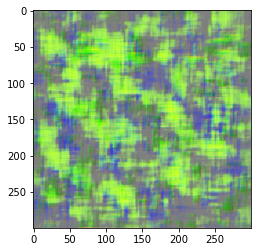

In [54]:
plt.imshow(x_treino_cod[0])

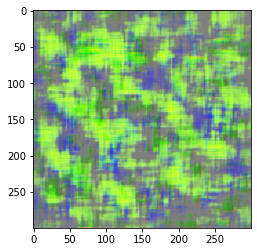

In [56]:
plt.imshow(x_valid_cod[0])

# rede primaria

In [57]:
cnn_i, cnn_j, cnn_chnls = 300, 300, 3

cnn = Sequential()
cnn.add(Conv2D(50, (3, 3), input_shape = (cnn_i, cnn_j, cnn_chnls), activation = 'relu'))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(MaxPool2D((2, 2)))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(AvgPool2D((2, 2)))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(BatchNormalization())
cnn.add(AvgPool2D((2, 2)))
cnn.add(Flatten())
cnn.add(Dense(25, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dropout(0.2))
cnn.add(Dense(25, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.2))
cnn.add(Dense(25, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dropout(0.2))
cnn.add(Dense(25, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dense(1, activation = 'relu'))
        
cnn.compile(loss = 'binary_crossentropy', optimizer = RMSprop(learning_rate = 0.001))

es = EarlyStopping(monitor = 'loss', patience = 5) 

In [58]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 298, 298, 50)      1400      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 296, 296, 50)      22550     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 148, 148, 50)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 146, 146, 50)      22550     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 144, 144, 50)      22550     
_________________________________________________________________
average_pooling2d (AveragePo (None, 72, 72, 50)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 70, 70, 50)        2

In [59]:
batch_size = 100

# Rede com o encoder

# Testaremos o encoder inteiro nessa primeira rede para ver se ele dá algum ganho preditivo em relação ao modelo sem encoder

In [61]:
es = EarlyStopping(patience = 5, restore_best_weights = True)

cnn.fit(x_treino_cod, y_treino, 
             epochs = 100,
             validation_data = (x_valid_cod, y_valid),
             callbacks = [es])

Epoch 1/100
75/75 [==============================] - 542s 7s/step - loss: 7.2929 - val_loss: 4.1658
Epoch 2/100
75/75 [==============================] - 525s 7s/step - loss: 4.5573 - val_loss: 3.3255
Epoch 3/100
75/75 [==============================] - 523s 7s/step - loss: 3.6478 - val_loss: 2.9830
Epoch 4/100
75/75 [==============================] - 521s 7s/step - loss: 2.9755 - val_loss: 2.4990
Epoch 5/100
75/75 [==============================] - 504s 7s/step - loss: 2.5327 - val_loss: 2.1962
Epoch 6/100
75/75 [==============================] - 494s 7s/step - loss: 1.9167 - val_loss: 1.7699
Epoch 7/100
75/75 [==============================] - 492s 7s/step - loss: 1.4936 - val_loss: 1.3402
Epoch 8/100
75/75 [==============================] - 492s 7s/step - loss: 1.1983 - val_loss: 1.1949
Epoch 9/100
75/75 [==============================] - 491s 7s/step - loss: 1.0529 - val_loss: 0.9803
Epoch 10/100
75/75 [==============================] - 497s 7s/step - loss: 0.8804 - val_loss: 0.8552

In [62]:
y_treino_pred = cnn.predict(x_treino_cod)

In [64]:
roc_auc_score(y_treino, y_treino_pred)

0.7878179204437352

# Rede sem o encoder

In [65]:
es = EarlyStopping(patience = 5, restore_best_weights = True)

cnn.fit(x_treino, y_treino, 
             epochs = 100,
             validation_data = (x_valid, y_valid),
             callbacks = [es])

Epoch 1/100
75/75 [==============================] - 494s 7s/step - loss: 0.7654 - val_loss: 4.0895
Epoch 2/100
75/75 [==============================] - 491s 7s/step - loss: 0.7845 - val_loss: 1.2205
Epoch 3/100
75/75 [==============================] - 501s 7s/step - loss: 0.7351 - val_loss: 1.1920
Epoch 4/100
75/75 [==============================] - 492s 7s/step - loss: 0.7375 - val_loss: 5.2102
Epoch 5/100
75/75 [==============================] - 495s 7s/step - loss: 0.8029 - val_loss: 1.2600
Epoch 6/100
75/75 [==============================] - 498s 7s/step - loss: 0.7242 - val_loss: 2.5924
Epoch 7/100
75/75 [==============================] - 500s 7s/step - loss: 0.7948 - val_loss: 1.0614
Epoch 8/100
75/75 [==============================] - 488s 7s/step - loss: 0.7423 - val_loss: 1.0958
Epoch 9/100
75/75 [==============================] - 487s 6s/step - loss: 0.7310 - val_loss: 0.9955
Epoch 10/100
75/75 [==============================] - 487s 6s/step - loss: 0.6975 - val_loss: 1.4554

In [66]:
y_treino_pred = cnn.predict(x_treino)

In [67]:
roc_auc_score(y_treino, y_treino_pred)

0.7544713470511655

# salvando o gargalo

In [45]:
encoder = Model(inputs = autoencoder.input, outputs = autoencoder.get_layer('gargalo').output)
encoder.save('gargalo.h5')

# Complexificando a rede

In [47]:
x_treino_cod = encoder.predict(x_treino)
x_valid_cod = encoder.predict(x_valid)

In [52]:
x_treino_cod.shape

(2379, 60)

## Com o encoder

In [53]:
cnn_i, cnn_j = 2379, 60

cnn = Sequential()
cnn.add(Conv2D(100, (3, 3), input_shape = (cnn_i, cnn_j), activation = 'relu'))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(MaxPool2D((2, 2)))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(AvgPool2D((2, 2)))
cnn.add(Conv2D(100, (3, 3), activation = 'relu'))
cnn.add(BatchNormalization())
cnn.add(AvgPool2D((2, 2)))
cnn.add(Flatten())
cnn.add(Dense(25, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dropout(0.2))
cnn.add(Dense(150, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.2))
cnn.add(Dense(150, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dropout(0.2))
cnn.add(Dense(100, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dense(1, activation = 'relu'))
        
cnn.compile(loss = 'binary_crossentropy', optimizer = RMSprop(learning_rate = 0.001))

es = EarlyStopping(monitor = 'loss', patience = 5) 

ValueError: Input 0 of layer conv2d_7 is incompatible with the layer: expected ndim=4, found ndim=3. Full shape received: [None, 2379, 60]

In [ ]:
es = EarlyStopping(patience = 5, restore_best_weights = True)

cnn.fit(x_treino_cod, y_treino, 
             epochs = 100,
             validation_data = (x_valid_cod, y_valid),
             callbacks = [es])

In [62]:
y_treino_pred = cnn.predict(x_treino_cod)

In [64]:
roc_auc_score(y_treino, y_treino_pred)

0.7878179204437352

# Sem o encoder

In [67]:
cnn_i, cnn_j, cnn_chnls = 300, 300, 3

cnn = Sequential()
cnn.add(Conv2D(100, (3, 3), input_shape = (cnn_i, cnn_j, cnn_chnls), activation = 'relu'))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(MaxPool2D((2, 2)))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(AvgPool2D((2, 2)))
cnn.add(Conv2D(100, (3, 3), activation = 'relu'))
cnn.add(BatchNormalization())
cnn.add(AvgPool2D((2, 2)))
cnn.add(Flatten())
cnn.add(Dense(25, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dropout(0.2))
cnn.add(Dense(150, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.2))
cnn.add(Dense(150, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dropout(0.2))
cnn.add(Dense(100, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dense(1, activation = 'relu'))
        
cnn.compile(loss = 'binary_crossentropy', optimizer = RMSprop(learning_rate = 0.001))

es = EarlyStopping(monitor = 'loss', patience = 5) 

In [68]:
cnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 298, 298, 100)     2800      
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 296, 296, 50)      45050     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 148, 148, 50)      0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 146, 146, 50)      22550     
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 144, 144, 50)      22550     
_________________________________________________________________
average_pooling2d_6 (Average (None, 72, 72, 50)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 70, 70, 100)      

In [69]:
batch_size = 100

In [70]:
es = EarlyStopping(patience = 5, restore_best_weights = True)

cnn.fit(x_treino, y_treino, 
             epochs = 100,
             validation_data = (x_valid, y_valid),
             callbacks = [es])

Epoch 1/100
75/75 [==============================] - 865s 12s/step - loss: 16.8028 - val_loss: 18.4377
Epoch 2/100
75/75 [==============================] - 817s 11s/step - loss: 11.5329 - val_loss: 16.1671
Epoch 3/100
75/75 [==============================] - 805s 11s/step - loss: 8.7762 - val_loss: 10.7186
Epoch 4/100
75/75 [==============================] - 815s 11s/step - loss: 6.3133 - val_loss: 12.1226
Epoch 5/100
75/75 [==============================] - 793s 11s/step - loss: 4.4743 - val_loss: 6.1139
Epoch 6/100
75/75 [==============================] - 794s 11s/step - loss: 3.1176 - val_loss: 2.3271
Epoch 7/100
75/75 [==============================] - 804s 11s/step - loss: 1.9175 - val_loss: 3.9498
Epoch 8/100
75/75 [==============================] - 807s 11s/step - loss: 1.2816 - val_loss: 1.3688
Epoch 9/100
75/75 [==============================] - 795s 11s/step - loss: 1.0344 - val_loss: 1.2685
Epoch 10/100
75/75 [==============================] - 807s 11s/step - loss: 0.9841 - 

In [71]:
y_treino_pred = cnn.predict(x_treino)

In [72]:
roc_auc_score(y_treino, y_treino_pred)

0.36031501917452713

In [73]:
cnn.save("2_rede_sem_encoder")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: 2_rede_sem_encoder/assets


# Terceira rede sem encoder

In [74]:
cnn_i, cnn_j, cnn_chnls = 300, 300, 3

cnn = Sequential()
cnn.add(Conv2D(50, (3, 3), input_shape = (cnn_i, cnn_j, cnn_chnls), activation = 'relu'))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(MaxPool2D((2, 2)))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(AvgPool2D((2, 2)))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(BatchNormalization())
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(AvgPool2D((2, 2)))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(BatchNormalization())
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(Flatten())
cnn.add(Dense(10, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dropout(0.2))
cnn.add(Dense(300, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dense(200, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.2))
cnn.add(Dense(250, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dropout(0.2))
cnn.add(Dense(150, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.2))
cnn.add(Dense(25, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dropout(0.2))
cnn.add(Dense(25, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dense(1, activation = 'relu'))
        
cnn.compile(loss = 'binary_crossentropy', optimizer = RMSprop(learning_rate = 0.001))


In [75]:
cnn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 298, 298, 50)      1400      
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 296, 296, 50)      22550     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 148, 148, 50)      0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 146, 146, 50)      22550     
_________________________________________________________________
average_pooling2d_8 (Average (None, 73, 73, 50)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 71, 71, 50)        22550     
_________________________________________________________________
batch_normalization_14 (Batc (None, 71, 71, 50)       

In [76]:
batch_size = 100

In [77]:
es = EarlyStopping(patience = 5, restore_best_weights = True)

cnn.fit(x_treino, y_treino, 
             epochs = 100,
             validation_data = (x_valid, y_valid),
             callbacks = [es])

Epoch 1/100
75/75 [==============================] - 492s 7s/step - loss: 32.8494 - val_loss: 31.9427
Epoch 2/100
75/75 [==============================] - 490s 7s/step - loss: 20.2678 - val_loss: 15.4807
Epoch 3/100
75/75 [==============================] - 491s 7s/step - loss: 12.5662 - val_loss: 14.6367
Epoch 4/100
75/75 [==============================] - 472s 6s/step - loss: 6.1602 - val_loss: 4.7260
Epoch 5/100
75/75 [==============================] - 472s 6s/step - loss: 2.4652 - val_loss: 1.7085
Epoch 6/100
75/75 [==============================] - 474s 6s/step - loss: 1.2626 - val_loss: 1.1134
Epoch 7/100
75/75 [==============================] - 470s 6s/step - loss: 0.9714 - val_loss: 1.0407
Epoch 8/100
75/75 [==============================] - 472s 6s/step - loss: 0.8143 - val_loss: 0.8254
Epoch 9/100
75/75 [==============================] - 486s 6s/step - loss: 0.7952 - val_loss: 0.8613
Epoch 10/100
75/75 [==============================] - 486s 6s/step - loss: 0.7882 - val_loss: 

In [ ]:
y_treino_pred = cnn.predict(x_treino)

In [ ]:
roc_auc_score(y_treino, y_treino_pred)

In [ ]:
cnn.save("3_rede_sem_encoder")

# Quarta rede sem encoder

In [ ]:
cnn_i, cnn_j, cnn_chnls = 300, 300, 3

cnn = Sequential()
cnn.add(Conv2D(350, (3, 3), input_shape = (cnn_i, cnn_j, cnn_chnls), activation = 'relu'))
cnn.add(Conv2D(150, (3, 3), activation = 'relu'))
cnn.add(MaxPool2D((2, 2)))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(AvgPool2D((2, 2)))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(BatchNormalization())
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(AvgPool2D((2, 2)))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(BatchNormalization())
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(Flatten())
cnn.add(Dense(10, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dropout(0.2))
cnn.add(Dense(300, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dense(200, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.2))
cnn.add(Dense(250, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dropout(0.2))
cnn.add(Dense(200, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.2))
cnn.add(Dense(25, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dropout(0.2))
cnn.add(Dense(25, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dense(1, activation = 'relu'))
        
cnn.compile(loss = 'binary_crossentropy', optimizer = RMSprop(learning_rate = 0.001))


In [ ]:
cnn.summary()

In [ ]:
batch_size = 100

In [ ]:
es = EarlyStopping(patience = 5, restore_best_weights = True)

cnn.fit(x_treino, y_treino, 
             epochs = 100,
             validation_data = (x_valid, y_valid),
             callbacks = [es])

In [ ]:
y_treino_pred = cnn.predict(x_treino)

In [ ]:
roc_auc_score(y_treino, y_treino_pred)

In [ ]:
cnn.save("4_rede_sem_encoder")